In [1]:
import json
import os
import requests
from glob import glob

import pandas as pd
from pandas.io.json import json_normalize
from sqlalchemy import create_engine
from tqdm import tqdm

%matplotlib inline

In [2]:
eng = create_engine('sqlite:///db/data.sqlite3', echo=False)

In [3]:
# # Create directories
# !mkdir images
# !mkdir data
# !mkdir db

## Image metadata

In [4]:
# # Download image metadata
# url = 'http://beyondwords.labs.loc.gov/data'
# r = requests.get(url, stream=True)
# with open('data/data.json', 'wb') as f:
#     for chunk in r.iter_content(): 
#         if chunk:
#             f.write(chunk)

In [6]:
# Load downloaded data
with open('data/data.json', encoding='utf-8') as jsonfile:
    data = json.load(jsonfile)['data']

In [7]:
# Show a couple of data entries
data[:2]

[{'id': '5b80678a6dc3580001001124',
  'location': {'standard': 'http://s3.amazonaws.com/ndnp-jpeg-surrogates/uuml_indurain_ver01/data/sn85058396/print/1917120701/0840.jpg'},
  'region': {'toolName': 'rectangleTool',
   'color': '#fe0000',
   'x': 2930.7938787736675,
   'y': 214.3306900288162,
   'width': 884.9766970618034,
   'height': 2820.868436508291,
   'label': 'Illustration/Photo'},
  'width': 6824,
  'height': 9092,
  'meta_data': {'set_key': 'http://chroniclingamerica.loc.gov/lccn/sn85058396/1917-12-07/ed-1/seq-11/',
   'subject_url': 'http://chroniclingamerica.loc.gov/lccn/sn85058396/1917-12-07/ed-1/seq-11/',
   'subject_description': 'The Ogden standard. December 07, 1917. Page 11',
   'resize': '1.000000',
   'alto': 'http://s3.amazonaws.com/ndnp-batches/uuml_indurain_ver01/data/sn85058396/print/1917120701/0840.xml'},
  'data': {'values': [{'caption': 'BRITISH HOLD CAMBRAI GAINS\nAttack after attack by the Germans against the British positions in the vicinity of Cambrai have

In [8]:
# Restructure data for consistency: sometimes 
# the 'data' attribute is at root level; somtimes
# it's nested under a 'values' attribute
for i, doc in enumerate(data):
    values_attrib = doc['data'].get('values')
    if values_attrib: 
        data[i]['data'] = values_attrib[0]

In [9]:
# Flatten data into dataframe
df = json_normalize(data)
# json_normalize uses periods in col names; change to underscore
df.columns = df.columns.map(lambda x: x.replace('.', '_'))

# Show a couple of dataframe entries
df.head(3)

,data_caption,data_category,data_creator,height,id,location_standard,meta_data_alto,meta_data_resize,meta_data_set_key,meta_data_subject_description,meta_data_subject_url,region_color,region_height,region_label,region_toolName,region_width,region_x,region_y,width
0,BRITISH HOLD CAMBRAI GAINS\nAttack after attac...,Map,NaN,9092,5b80678a6dc3580001001124,http://s3.amazonaws.com/ndnp-jpeg-surrogates/u...,http://s3.amazonaws.com/ndnp-batches/uuml_indu...,1.000000,http://chroniclingamerica.loc.gov/lccn/sn85058...,"The Ogden standard. December 07, 1917. Page 11",http://chroniclingamerica.loc.gov/lccn/sn85058...,#fe0000,2820.868437,Illustration/Photo,rectangleTool,884.976697,2930.793879,214.330690,6824
1,EXPERTS TEACHING WOMEN--AND SOME MEN--ECONOMY ...,Photograph,NaN,9169,5b7b075ed6342b0001002bd4,http://s3.amazonaws.com/ndnp-jpeg-surrogates/u...,http://s3.amazonaws.com/ndnp-batches/uuml_indu...,1.000000,http://chroniclingamerica.loc.gov/lccn/sn85058...,"The Ogden standard. October 05, 1917. Page 4",http://chroniclingamerica.loc.gov/lccn/sn85058...,#fe0000,2664.602557,Illustration/Photo,rectangleTool,1754.099291,233.656697,6065.653057,6608
2,Scenes with the Carl Hagenbeck and Wallace Circus,Photograph,NaN,6169,5b8071666dc358000100112d,http://s3.amazonaws.com/ndnp-jpeg-surrogates/u...,http://s3.amazonaws.com/ndnp-batches/uuml_bass...,1.000000,http://chroniclingamerica.loc.gov/lccn/sn85058...,"The Logan Republican. July 14, 1917. Page 9",http://chroniclingamerica.loc.gov/lccn/sn85058...,#fe0000,2598.621354,Illustration/Photo,rectangleTool,1880.826748,1912.173832,3189.217116,4484


In [ ]:
# # Drop columns we probably won't need
# drop_cols = [
#     'meta_data_resize',
#     'region_color',
#     'region_toolName',
#     'region_label',
# ]
# for col in drop_cols:
#     df.drop(col, axis=1, inplace=True)

In [10]:
# Show data types inferred by pandas
df.dtypes

data_caption                      object
data_category                     object
data_creator                      object
height                             int64
id                                object
location_standard                 object
meta_data_alto                    object
meta_data_resize                  object
meta_data_set_key                 object
meta_data_subject_description     object
meta_data_subject_url             object
region_color                      object
region_height                    float64
region_label                      object
region_toolName                   object
region_width                     float64
region_x                         float64
region_y                         float64
width                              int64
dtype: object

In [11]:
# Convert NaNs in text columns to blanks
obj_cols = list(df.select_dtypes(include=['object']).columns)
for col in obj_cols:
    df[col] = df[col].fillna('')

In [12]:
# Get colum counts
df.count()

data_caption                     1778
data_category                    1778
data_creator                     1778
height                           1778
id                               1778
location_standard                1778
meta_data_alto                   1778
meta_data_resize                 1778
meta_data_set_key                1778
meta_data_subject_description    1778
meta_data_subject_url            1778
region_color                     1778
region_height                    1778
region_label                     1778
region_toolName                  1778
region_width                     1778
region_x                         1778
region_y                         1778
width                            1778
dtype: int64

In [13]:
# Add column that is an md5 hash of the image url,
# to use as a uniqe image id
import hashlib

# func to return hash for a string
def hashstr(s):
    return hashlib.md5(s.encode('utf8')).hexdigest()

# apply to new column
df['img_url_hash'] = df.apply(lambda r: hashstr(r['location_standard']), axis=1)

In [14]:
# Save data as sqlite db
df.to_sql('data', eng, index=False, if_exists='replace')

In [15]:
# Re-read data from sql and check data types
pd.read_sql("select * from data", eng).dtypes

data_caption                      object
data_category                     object
data_creator                      object
height                             int64
id                                object
location_standard                 object
meta_data_alto                    object
meta_data_resize                  object
meta_data_set_key                 object
meta_data_subject_description     object
meta_data_subject_url             object
region_color                      object
region_height                    float64
region_label                      object
region_toolName                   object
region_width                     float64
region_x                         float64
region_y                         float64
width                              int64
img_url_hash                      object
dtype: object

In [16]:
# Re-read data from sql and check counts
pd.read_sql("select * from data", eng).count()

data_caption                     1778
data_category                    1778
data_creator                     1778
height                           1778
id                               1778
location_standard                1778
meta_data_alto                   1778
meta_data_resize                 1778
meta_data_set_key                1778
meta_data_subject_description    1778
meta_data_subject_url            1778
region_color                     1778
region_height                    1778
region_label                     1778
region_toolName                  1778
region_width                     1778
region_x                         1778
region_y                         1778
width                            1778
img_url_hash                     1778
dtype: int64

## Image files

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5287598940>]],
      dtype=object)

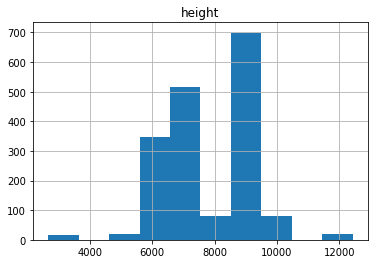

In [17]:
# Look at image heights
df.hist(column='height')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5287c38cf8>]],
      dtype=object)

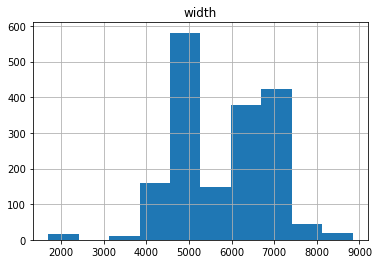

In [18]:
# look at image widths
df.hist(column='width')

In [16]:
# Download image corresponding to each unique image hash,
sql = "select distinct location_standard, img_url_hash from data"
img_list = list(eng.execute(sql))
for row in tqdm(img_list):
    uhash = row[1]
    url = row[0]

    # image filename is based on url hash
    path = 'images/{}.jpg'.format(uhash)
    
    # download, if file doesn't exist
    if not os.path.exists(path):
        r = requests.get(url, stream=True)
        with open(path, 'wb') as f:
            for chunk in r.iter_content(2048):
                if chunk:
                    f.write(chunk)

100%|██████████| 1106/1106 [00:00<00:00, 3134.60it/s]


In [27]:
# Check number of image files 
len(glob('images/*.jpg'))

1106

## Manipulate image files
Image files are very large. Resize.

In [ ]:
import os, warnings
from shutil import copy2
from glob import glob

from skimage import io, exposure, transform
from tqdm import tqdm

imgdir = 'images/'
modimgdir = 'images/modified/'

if not os.path.exists(modimgdir):
    os.makedirs(modimgdir)

for imgpath in tqdm(glob('images/*.jpg')):
    with warnings.catch_warnings(): # suppress skimage warnings
        warnings.simplefilter("ignore")

        fname = os.path.basename(imgpath)
    
        img = io.imread(imgpath)
        scale = 1024 / img.shape[0] # scale to get a max height of 1024
        if scale < 1:
            img = transform.rescale(img, scale, anti_aliasing=True, multichannel=False, mode='reflect')
        io.imsave(modimgdir + fname, img, quality=90)
